## Wyniki analizy dla zbioru `KLEJ` - [PolEmo2.0-IN](https://clarin-pl.eu/dspace/handle/11321/710). ## 
Zestaw recenzji online z dziedziny medycyny i hoteli. 
Przewidzywanie sentymentu recenzji.

W ramach analizy wykorzystano sieci LSTM

Dla LSTM analizę wykonano na 3 zbiorach:
* `oryg` - oryginalny zbiór, bez modyfikacji podzielony na proste tokeny
* `prep` - zbiór po zostosowaniu preprocessingu z notatników z kursu + simple_preprocess z Gensima
* `spacy` - to samo co w zbiorze `prep`, ale tokeny są tokeny zostały uzyskane z modułu `Spacy`

## Przygotowanie danych ##

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_oryg = pd.read_csv('LSTM_X_oryg.csv')
df_prep = pd.read_csv('LSTM_X_prep.csv')
df_spacy = pd.read_csv('LSTM_X_sm_spacy_tokenizer.csv')

In [3]:
df_oryg.dropna(inplace=True)
df_prep.dropna(inplace=True)
df_spacy.dropna(inplace=True)

In [4]:
df_oryg.drop_duplicates(inplace=True)
df_prep.drop_duplicates(inplace=True)
df_spacy.drop_duplicates(inplace=True)

In [5]:
exclude_cols = ['Unnamed: 0', 'run_id', 'experiment_id', 'status', 'artifact_uri', 'tags.mlflow.user', 'start_time', 'end_time', 'tags.mlflow.source.name',\
     'tags.mlflow.source.type','tags.mlflow.runName', 'Run ID', 'Name', 'Source Type', 'Source Name', 'User', 'Status']

In [6]:
lstm_df = [df_oryg, df_prep, df_spacy]

In [7]:
df_oryg = df_oryg[[c for c in df_oryg.columns if c not in exclude_cols]]
df_prep = df_prep[[c for c in df_prep.columns if c not in exclude_cols]]
df_spacy= df_spacy[[c for c in df_spacy.columns if c not in exclude_cols]]

In [8]:
metrics = [elem.replace('metrics.', '') for elem in df_oryg.columns.to_list() if elem.startswith('metrics.')]
params = [elem.replace('params.', '') for elem in df_oryg.columns.to_list() if elem.startswith('params.')]


In [9]:
metrics_val = [elem for elem in metrics if elem.startswith('val')]
metrics_train = [elem for elem in metrics if elem.startswith('train')]

In [10]:
df_prep.rename(columns = lambda x: x.replace('metrics.', ''), inplace=True)
df_oryg.rename(columns = lambda x: x.replace('metrics.', ''), inplace=True)
df_prep.rename(columns = lambda x: x.replace('params.', ''), inplace=True)
df_oryg.rename(columns = lambda x: x.replace('params.', ''), inplace=True)


C:\Users\mariu\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# Monitory są szersze niż wyższe, więc wolę na starcie zrobić transpozycję, na przykładowych obserwacjach bo sądzę, że można więcej nazw cech (+ wartości przykładowych obserwacji) ogarnąć
# jednym spojrzeniem po transpozycji niż normalnie przewijac tabelkę w bok
df_oryg.sample(4).T

,17,12,104,62
val_precision_max,0.796207,1.0,0.771211,0.801778
train_precision_max,0.765525,0.762686,0.786574,0.771047
val_accuracy_max,0.70087,0.713043,0.709565,0.709565
val_accuracy_curr,0.70087,0.713043,0.704348,0.709565
train_accuracy_curr,0.699942,0.711356,0.735152,0.714065
val_recall_max,0.636533,0.634983,0.662492,0.642878
train_recall_max,0.610111,0.629912,0.662278,0.64097
val_f1_curr,0.696785,0.700949,0.696785,0.696615
train_precision_curr,0.699942,0.711356,0.735152,0.714065
train_f1_curr,0.67891,0.689743,0.718977,0.699682


W tabeli `nob` oznacz `number of bidirectional layers`

## Najlepsze wyniki dla f1 ##

In [12]:
def extract_best_metrics(dataset, metric):
    val_curr = max(dataset[f'val_{metric}_curr'])
    train_curr = max(dataset[f'train_{metric}_curr'])
    val_max = max(dataset[f'val_{metric}_max'])
    train_max = max(dataset[f'train_{metric}_max'])
    return train_curr, train_max, val_curr, val_max

In [13]:
d = dict()
d['oryg'] = extract_best_metrics(df_oryg, 'f1')
d['prep'] = extract_best_metrics(df_prep, 'f1')
d['spacy'] = extract_best_metrics(df_spacy, 'f1')

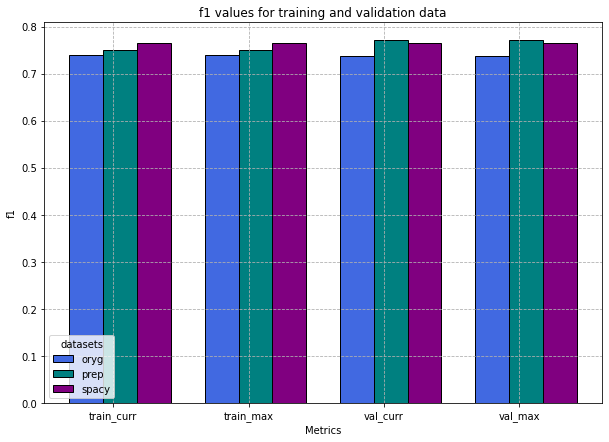

In [14]:
n=4
r = np.arange(n)
width = 0.25
plt.figure(figsize=(10,7))
  
plt.grid(linestyle='--')
plt.bar(r, d['oryg'], color = 'royalblue',
        width = width, edgecolor = 'black',
        label='oryg')
plt.bar(r + width, d['prep'], color = 'teal',
        width = width, edgecolor = 'black',
        label='prep')
plt.bar(r + width+width, d['spacy'], color = 'purple',
        width = width, edgecolor = 'black',
        label='spacy')
  
plt.xlabel("Metrics")
plt.ylabel("f1")

plt.title("f1 values for training and validation data")
  
plt.xticks(r + width/1.25,['train_curr','train_max', 'val_curr', 'val_max'])
plt.legend(title='datasets', loc='lower left');

In [15]:
print((d['spacy'][0] - d['oryg'][0]))
print((d['prep'][0] - d['oryg'][0]))
print((d['spacy'][1] - d['oryg'][1]))
print((d['prep'][1] - d['oryg'][1]))

0.025981783866882324
0.011210143566131592
0.025981783866882324
0.011210143566131592


In [16]:
print((d['spacy'][2] - d['oryg'][2]))
print((d['prep'][2] - d['oryg'][2]))
print((d['spacy'][3] - d['oryg'][3]))
print((d['prep'][3] - d['oryg'][3]))

0.026630520820617676
0.032652974128723145
0.028059661388397217
0.032652974128723145


## ***`WNIOSKI`*** ##
Wnioski dotyczą najlepszych uzyskanych modeli  

Odpowiedni preprocessing danych pozwala na zwiększenie wartości metryki.  
Na zbiorze treningowym preprocessing oferowany przez Spacy poprawił wartość metryki o 0.0259, a preprocessing ręczny + Gensima o 0.0112  
Na zbiorze validacyjnym zanotowany większy wzrost metryki po zastosowaniu preoprocesingu: preprocessing ręczny + Gensima poprawił wynik o 0.0327, a preprocessing Spacy'ego tylko 0.0266

In [17]:
def show_best(df, metric_name):
    ret = df[df[metric_name] == max(df[metric_name])][['max_opinion_length','model','unit','epoch','nob','max_top_words']]
    return ret

## Najlepsze modele dla poszczególnych zbiorów danych: ##

In [18]:
show_best(df_oryg, 'val_f1_curr')['model'].iloc[0]

'Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=500, units=64, epochs=10, nobs=2)'

In [19]:
show_best(df_prep, 'val_f1_curr')['model'].iloc[0]

'Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=2)'

In [20]:
show_best(df_spacy, 'val_f1_curr')['model'].iloc[0]

'Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=2)'

## Co najbardziej wpływa na wartość metryki f1 ##

In [21]:
pd.set_option("max_colwidth", 130)
pd.options.display.max_rows = 999
df_oryg.sort_values(by='val_f1_curr', ascending=False)[['model','max_top_words', 'max_opinion_length', 'unit', 'epoch', 'nob', 'val_f1_curr']]

,model,max_top_words,max_opinion_length,unit,epoch,nob,val_f1_curr
84,"Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=500, units=64, epochs=10, nobs=2)",500.0,60.0,64.0,10.0,2.0,0.737683
101,"Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=500, units=64, epochs=10, nobs=2)",500.0,60.0,64.0,10.0,2.0,0.737683
86,"Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=2)",500.0,60.0,64.0,10.0,2.0,0.735700
103,"Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=2)",500.0,60.0,64.0,10.0,2.0,0.735700
72,"Embedding (max_top_words=500, max_opinion_length=50, embedding_vector_lengths=500, units=64, epochs=10, nobs=2)",500.0,50.0,64.0,10.0,2.0,0.728960
24,"Embedding (max_top_words=300, max_opinion_length=50, embedding_vector_lengths=500, units=64, epochs=10, nobs=2)",300.0,50.0,64.0,10.0,2.0,0.725345
97,"Embedding (max_top_words=500, max_opinion_length=50, embedding_vector_lengths=500, units=64, epochs=10, nobs=0)",500.0,50.0,64.0,10.0,0.0,0.722255
80,"Embedding (max_top_words=500, max_opinion_length=50, embedding_vector_lengths=500, units=64, epochs=10, nobs=0)",500.0,50.0,64.0,10.0,0.0,0.722255
78,"Embedding (max_top_words=500, max_opinion_length=50, embedding_vector_lengths=400, units=64, epochs=10, nobs=1)",500.0,50.0,64.0,10.0,1.0,0.719703
73,"Embedding (max_top_words=500, max_opinion_length=50, embedding_vector_lengths=500, units=32, epochs=10, nobs=2)",500.0,50.0,32.0,10.0,2.0,0.716132


In [22]:
df_oryg.corr()[['val_f1_max', 'val_f1_curr']].iloc[[18,19, 21,22]].sort_values(by='val_f1_max', ascending=False)

,val_f1_max,val_f1_curr
max_opinion_length,0.904691,0.903418
max_top_words,0.106521,0.108232
nob,0.069502,0.076825
unit,0.042581,0.049018


In [23]:
df_prep.corr()[['val_f1_max', 'val_f1_curr']].iloc[[18,19,20,22]].sort_values(by='val_f1_max', ascending=False)

,val_f1_max,val_f1_curr
max_opinion_length,0.873883,0.871486
nob,0.226033,0.229465
unit,0.067193,0.060509
max_top_words,0.048754,0.046073


In [24]:
df_spacy.corr()[['val_f1_max', 'val_f1_curr']].iloc[1:5].sort_values(by='val_f1_max', ascending=False)

,val_f1_max,val_f1_curr
max_opinion_length,0.909579,0.910043
nob,0.164026,0.172120
unit,0.065147,0.048700
max_top_words,-0.028367,-0.030981


In [25]:
df_oryg['max_opinion_length'].unique()

array([10., 40., 50., 60.])

In [26]:
df_oryg[['max_opinion_length', 'val_f1_curr', 'val_f1_max']].groupby('max_opinion_length').agg([np.min, np.max, np.median])

val_f1_curr                     val_f1_max            \
                          amin      amax    median       amin      amax   
max_opinion_length                                                        
10.0                  0.409763  0.459809  0.442129   0.424661  0.467704   
40.0                  0.658936  0.704770  0.690296   0.670720  0.707267   
50.0                  0.658968  0.728960  0.692272   0.659306  0.732983   
60.0                  0.665156  0.737683  0.678903   0.665156  0.737683   

                              
                      median  
max_opinion_length            
10.0                0.448038  
40.0                0.694269  
50.0                0.692272  
60.0                0.684382

In [27]:
df_prep[['max_opinion_length', 'val_f1_curr', 'val_f1_max']].groupby('max_opinion_length').agg([np.min, np.max, np.median])

val_f1_curr                     val_f1_max            \
                          amin      amax    median       amin      amax   
max_opinion_length                                                        
10                    0.494525  0.545645  0.519707   0.496550  0.545645   
40                    0.664919  0.748491  0.720468   0.679445  0.756158   
50                    0.653763  0.762125  0.730109   0.654727  0.762125   
60                    0.614727  0.770336  0.720156   0.642698  0.770336   

                              
                      median  
max_opinion_length            
10                  0.524175  
40                  0.723709  
50                  0.730109  
60                  0.720156

In [28]:
df_spacy[['max_opinion_length', 'val_f1_curr', 'val_f1_max']].groupby('max_opinion_length').agg([np.min, np.max, np.median])

val_f1_curr                     val_f1_max            \
                          amin      amax    median       amin      amax   
max_opinion_length                                                        
10.0                  0.505051  0.550368  0.516258   0.515496  0.553644   
40.0                  0.665054  0.730576  0.721031   0.682492  0.734546   
50.0                  0.663666  0.742034  0.712086   0.680530  0.752612   
60.0                  0.678539  0.764313  0.732188   0.678539  0.765742   

                              
                      median  
max_opinion_length            
10.0                0.529964  
40.0                0.724786  
50.0                0.714013  
60.0                0.733941

## ***`WNIOSKI`*** ##
Najlepszymi modelami dla poszczególnych zbiorów są:  
* oryg - Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=500, units=64, epochs=10, nobs=2)  
* prep - Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=2)  
* spacy - Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=2)  

Najbardziej na wartosć metryki wpływa `max_opinion_length`.  
Dla każdego zbioru najwyższe wartości metryki uzyskiwano przy `max_opinion_length` = 60. Mediana metryki f1 była największa dla długości 50 przy zbiorze `oryg` oraz `prep` oraz dla długości 60 dla zbioru `spacy` 


In [86]:
def draw_heatmap(df, x_var, y_var, metric_val, agg_arg = 'mean'):

    df_temp = df.groupby([x_var,y_var])[metric_val].agg(agg_arg).reset_index()
    df_temp = df_temp.pivot(index=x_var, columns=y_var, values=[metric_val]).reset_index()
    df_temp = df_temp.set_index(df_temp.columns[0])

    ax = sns.heatmap(df_temp, annot=True, fmt = '.3f', cmap="YlGnBu")
    
    ax.set_title(f'{metric_val} {agg_arg} value for {x_var} vs {y_var}')
    ax.set_xlabel(f'{y_var}')
    ax.set_ylabel(f'{x_var}')


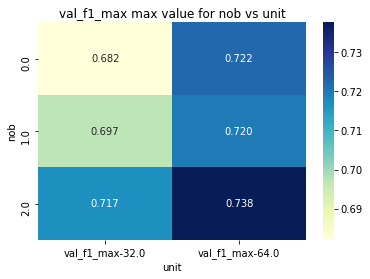

In [87]:
draw_heatmap(df_oryg, 'nob', 'unit', 'val_f1_max', 'max')

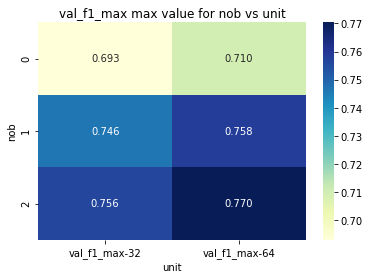

In [88]:
draw_heatmap(df_prep, 'nob', 'unit', 'val_f1_max', 'max')

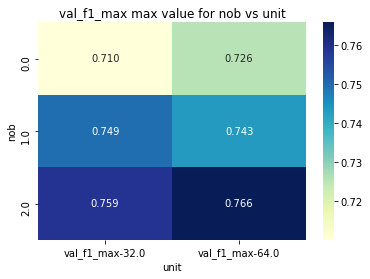

In [89]:
draw_heatmap(df_spacy, 'nob', 'unit', 'val_f1_max', 'max')

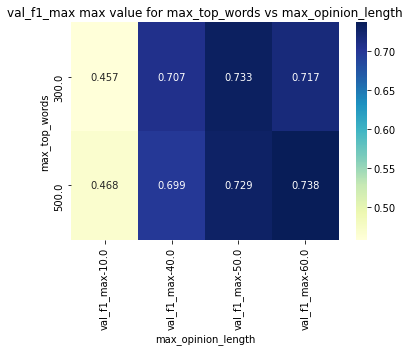

In [90]:
draw_heatmap(df_oryg, 'max_top_words', 'max_opinion_length', 'val_f1_max', 'max')

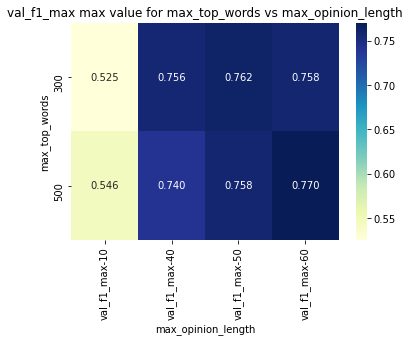

In [91]:

draw_heatmap(df_prep, 'max_top_words', 'max_opinion_length', 'val_f1_max', 'max')

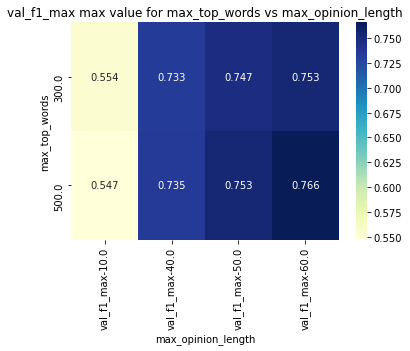

In [92]:
draw_heatmap(df_spacy, 'max_top_words', 'max_opinion_length', 'val_f1_max', 'max')

## ***`WNIOSKI`*** ##
Maksymalna wartość metryki f1 jest największa przy zbiorach przetworzonych.
Większe wartości uzyskuje się zwiększając ilość warstw dwukierunkowych oraz ilośći unitów.  
Większa wartość `max_top_words` zwiększa jedynie nieznacznie wartość metryki f1. Zbliżone wartości f1 otrzymano dla zbiorów przetworzonych wtedy kiedy:
* max_top_words = 300 i max_opinion_length = 60
oraz 
* max_top_words = 500 i max_opinion_length = 50
(odpowiednio 0.758 i 0.753 dla zbiorów `prep` i `spacy`)